# 2 практическое задание. Сегментация изображений.

## Практикум на ЭВМ для 317 группы, весна 2019

#### Фамилия, имя: 

Дата выдачи: 21 марта

Мягкий дедлайн: 30 марта 23:59 

В этом задании вы будете решать задачу сегментации людей на фотографии с помощью нейросетевых архитектур Unet и Linknet.

## Загрузка данных (1 балл)

Для загрузки данных pytorch опирается на такую сущность, как **`Dataset`**.

Этот абстрактный класс определен в `torch.utils.data.dataset`:

```python
class Dataset(object):
    """An abstract class representing a Dataset.

    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])
```
При определении нового источника данных мы создаем наследника данного класса и реализуем методы `__getitem__` и `__len__`.

Пример готового такого класса — `torchvision.datasets.ImageFolder`, который позволяет создать датасет на основе директории с imagenet-подобной структурой поддиректорий (`./train/{class}` и `./val/{class}`):

```python
imagenet = torchvision.datasets.ImageFolder('path/to/imagenet_root/')
```

Реализуйте класс PhotosDataset для выданных данных.

**Внимание.** Возможно, стоит прочитать следующий пункт задания, чтобы реализация была удобной.

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import torch
import torch.nn as nn

import numpy as np
import numpy.testing as npt

import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
from torch.utils.data.dataset import Dataset

In [0]:
class PhotosDataset(Dataset):
    def __init__(self, images_dir, images_names, target_dir=None, transforms=None):
        """
        Arguments
        ---------
        images_dir : str
            Path to directory with images
            
        images_names : list of str
            Images short names
            
        target_dir : str
            Path to directory with masks.
            Each mask corresponds to one image.
            Corresponding mask and image have the same name.
            
        transforms : some collection
            Sequence of transformations for images and masks. 
        """
        self.images_dir = images_dir
        self.images_names = images_names
        self.target_dir = target_dir
        self.transforms = transforms
        
    def __len__(self):
        return len(self.images_names)
        
                   
    def __getitem__(self, idx):
        """
        Arguments
        ---------
        idx : int
            Index of image and mask
        
        Returns
        -------
        (image, mask)
        """
        name = self.images_names[idx]
        image = Image.open(self.images_dir + '/' + str(name) + '.jpg')
        mask = Image.open(self.target_dir + '/' + str(name) + '.png')
        for (transform, args, kwargs) in self.transforms:
            curr_transform = transform(*args, **kwargs)
            image, mask = curr_transform(image, mask)
        return (image, mask)

## Модуль аугментации (3 балла)

Конструктор стандартного `ImageFolder`, принимают параметр `transform` (и иногда `target_transform`).

Они служат для того, чтобы загружаемые изображения (обычно это `PIL.Image`) или таргеты преобразовывать в тензоры нужного вида.

В `torchvision` входит модуль `transforms` для стандартных примеров таких преобразований. В `transforms` могут содержаться случайные преобразования, это самый простой путь для реализации аугментации данных.

При определении кастомного трансформера помимо конструктора нужно реализовать лишь метод `__call__`:

```python
class HorizontalFlip(object):
    def __init__(self, mode=0):
        self.method = mode

    def __call__(self, img):
        """
        Args:
            img (PIL.Image): Image to be flipped.

        Returns:
            PIL.Image: Randomly flipped image.
        """
        if self.method:
            return img.transpose(Image.FLIP_LEFT_RIGHT)
        return img

```

С полным списком стандартных преобразований можно ознакомиться в http://pytorch.org/docs/master/torchvision/transforms.html.

В данной части вам предлагается самостояльно реализовать несколько кастомных трансформеров.
Обратите внимание, что для некоторых трансформеров, необходимо преобразовывать и изображение, и маску, а для каких-то только изображение.

Один из путей реализации:
* реализовать декоратор, делающий любое преобразование случайным
* реализовать декоратор, применяющий преобразование и к изображению, и к маске

Список трансформеров, которые надо реализовать:

* случайное (с вероятностью p) горизонтальное отображение (flip) изображения 
* случайное (с веротностью p) вырезание фрагмента изображения (заданного или случайного размера)
* случайное (с вероятностью p) изменение яркости изображения (на заданную или случайную величину)
* случайное (с веротностью p) изменение фона изображения (на изображение из заданного списка изображений)

In [0]:
class BackgroundsDataset(Dataset):
    def __init__(self, images_dir, images_names):
        self.images_dir = images_dir
        self.images_names = images_names
        
    def __len__(self):
        return len(self.images_names)

    def __getitem__(self, idx):
        name = self.images_names[idx]
        return Image.open(self.images_dir + '/' + str(name) + '.jpg')

In [0]:
def random_decorator_args(p):
    def random_decorator(method):
        def wrapper(self, *args, **kwargs):
            mode = np.random.binomial(1, p, 1)
            return method(self, *args, **kwargs, mode=mode)
        return wrapper
    return random_decorator

def img_mask_decorator_args(mask_change, mask_arg):
    def img_mask_decorator(method):
        def wrapper(self, img, mask):
            if(mask_arg):
                img = method(self, mask, img) 
            else:
                img = method(self, img)
            if(mask_change):
                mask = method(self, mask)
            return (img, mask)
        return wrapper
    return img_mask_decorator

In [0]:
class HorizontalFlip(object):
    @random_decorator_args(0.5)
    def __init__(self, mode=0):
        self.mode=mode
    
    @img_mask_decorator_args(True, False)
    def __call__(self, img):
        """
        Args:
            img (PIL.Image): Image to be flipped.

        Returns:
            PIL.Image: Randomly flipped image.
        """
        if self.mode:
            return img.transpose(Image.FLIP_LEFT_RIGHT)
        return img

In [0]:
class Crop(object):
    @random_decorator_args(0.5)
    def __init__(self, output_size=None, mode=0):
        self.mode = mode
        self.output_size = output_size
        self.pad_flag = True  # if padding values were defined
        
            
    @img_mask_decorator_args(True, False) 
    def __call__(self, img):
        if(self.mode):
            input_size = img.size
            if(self.output_size == None):
                times = 1.0 - np.random.random_sample() * 0.2
                w = times * img.size[0]
                h = times * img.size[1]
                self.output_size = (int(w), int(h))
            if(self.pad_flag):
                self.x_pad = np.random.randint(0, img.size[0] - self.output_size[0])
                self.y_pad = np.random.randint(0, img.size[1] - self.output_size[1])
                self.pad_flag = False
            img = img.crop((self.x_pad, self.y_pad, self.x_pad + self.output_size[0], self.y_pad + self.output_size[1]))
            return img.resize(input_size)
        return img

In [0]:
class ChangeBrightness(object):
    @random_decorator_args(0.5)
    def __init__(self, brightness=None, mode=0):
        self.mode = mode
        self.brightness = brightness
        if(self.brightness is None):
            self.brightness = 1.0 - np.random.random_sample() * 0.2
        
    @img_mask_decorator_args(False, False)
    def __call__(self, img):
        if(self.mode):
            return ImageEnhance.Brightness(img).enhance(self.brightness)
        return img

In [0]:
class ChangeBackground(object):
    @random_decorator_args(0.5)
    def __init__(self, ds, mode=0):
        self.ds = ds
        self.mode = mode
        
    @img_mask_decorator_args(False, True)
    def __call__(self, mask, img):
        if(self.mode):
            bg_img = self.ds[np.random.randint(0, self.ds.__len__())]
            bg_img = bg_img.resize(img.size)
            return Image.composite(img, bg_img, mask)
        return img

Добавьте случайные преобразования в ваши датасеты. Также, добавьте преобразование в tensor и нормализацию для изображения:

```
transforms.ToTensor()
transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])
```

In [0]:
import glob
from torchvision.transforms.transforms import ToTensor, Normalize

ToTensor.__call__ = img_mask_decorator_args(True, False)(ToTensor.__call__)
Normalize.__call__ = img_mask_decorator_args(False, False)(Normalize.__call__)

In [0]:
DATA_PATH = '/content/gdrive/My Drive/task_2/'
train_len = len(glob.glob(DATA_PATH + 'train/*'))
test_len = len(glob.glob(DATA_PATH + 'test/*'))
bg_len = len(glob.glob(DATA_PATH + 'backgrounds/*'))

train_images = range(1, train_len + 1)
test_images = range(train_len + 1, train_len + test_len + 1)
bg_images = range(1, bg_len + 1)

bg_dataset = BackgroundsDataset(
    images_dir=DATA_PATH + 'backgrounds/', 
    images_names=bg_images
)

train_dataset = PhotosDataset(
    images_dir=DATA_PATH + 'train/',
    images_names=train_images,
    target_dir=DATA_PATH + 'train_mask/',
    transforms= [(ChangeBackground, [bg_dataset], {}), (HorizontalFlip, [], {}), (Crop, [], {}), 
                 (ChangeBrightness, [], {}), (ToTensor, [], {}), 
                (Normalize, [], {'mean': [0.485, 0.456, 0.406], 
                                'std' :[0.229, 0.224, 0.225]})]
)

test_dataset = PhotosDataset(
    images_dir=DATA_PATH + 'test/',
    images_names=test_images,
    target_dir=DATA_PATH + 'test_mask/',
    transforms= [(ToTensor, [], {}), (Normalize, [], {'mean':[0.485, 0.456, 0.406], 
                                                      'std':[0.229, 0.224, 0.225]})]
)


Функция для отображения изображения:

In [0]:
def show_idx_image(dataset, idx):
    mask_img = dataset[idx]

    image_to_show = mask_img[0].transpose(0, 1).transpose(1, 2).numpy()
    image_to_show = (image_to_show * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
    image_to_show = np.clip(image_to_show, 0, 1)

    mask_to_show = mask_img[1][0].numpy()

    fig, ax = plt.subplots(1, 3)
    fig.set_figwidth(7)
    fig.set_figheight(3)


    plt.subplot(1, 2, 1)
    plt.imshow(image_to_show)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask_to_show)
    plt.axis('off')

Отобразите несколько изображений и масок, на которых будет видна правильная работа вашего модуля аугментации данных.

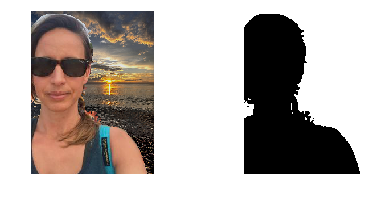

In [16]:
show_idx_image(train_dataset, 10)

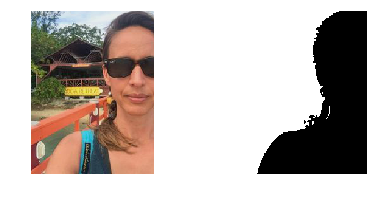

In [30]:
show_idx_image(train_dataset, 10)

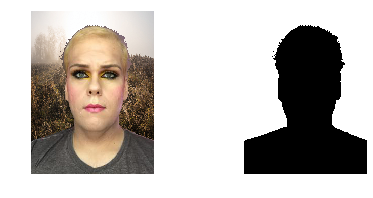

In [0]:
show_idx_image(train_dataset, 12)

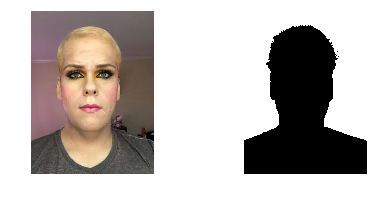

In [0]:
show_idx_image(train_dataset, 12)

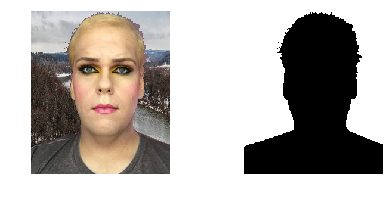

In [0]:
show_idx_image(train_dataset, 12)

### Загрузчики

При обучении сети удобнее работать не с датасетами, а с загрузчиками. Загрузчики создаются на основе датасета и позволяют итерироваться по батчам из него.

Обратите внимание на параметры DataLoader. При num_workers > 1, батчи готовятся (загружаются картинки, обрабатываются и т.д.) сразу в нескольких фоновых процессах. С помощью параметра shuffle можно подавать картинки на обучение в случайном порядке.

In [0]:
from torch.utils.data import DataLoader

In [0]:
train_data_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=8)

## DiceLoss (1 балл)

Функция потерь реализовывается как и все стандартные нейронные модули в pytorch, через nn.Module. В ячейке ниже вам предлагается реализовать фукцию потерь dice (аналог меры Джаккарда).

Dice loss определим как:

$$
1 - \frac{2\sum_{i, j}a_{ij}b_{ij}}{\sum_{ij}(a_{ij} + b_{ij} + \varepsilon)}
$$

где $a_{ij} \in [0, 1]$ — предсказанная вероятность нахождения человека в пикселе изображения, $b_{ij}$ — разметка для пикселя изображения.


In [0]:
class DiceLoss(nn.Module):
    def __init__(self, eps=1e-7, reduction='none', with_logits=True):
        """
        Arguments
        ---------
        eps : float
            eps in denominator
        reduction : string ('none', 'mean' or 'sum')
            specifies the reduction to apply to the output:
            
            'none': no reduction will be applied
            'mean': the sum of the output will be divided by the number of batches in the output
            'sum':  the output will be summed. 
        with_logits : bool
            If True, use additional sigmoid for inputs
        """
        super().__init__()
        self.eps = eps
        self.reduction = reduction
        self.with_logits = with_logits
        
    def forward(self, logits, true_labels):
        """
        Arguments
        ----------
        self: torch.tensor of shape [batsh_size, width, high], type=int
        logits: torch.tensor of shape  [batsh_size, width, high], type=float
        
        """
        true_labels = true_labels.float()
        
        if self.with_logits:
            logits = torch.sigmoid(logits)
        
        dims = len(true_labels.size())
        mult = logits * true_labels
        sum_ = logits + true_labels + self.eps
        
        for i in range(dims - 1):
            mult = torch.sum(mult, dim=-1)
            sum_ = torch.sum(sum_, dim=-1)
        
        loss_value = 1 - (2 * mult) / sum_
        
        if self.reduction == 'sum':
            loss_value = torch.sum(loss_value)
        elif self.reduction == 'mean':
            loss_value = torch.mean(loss_value)
        elif self.reduction == 'none':
            loss_value = loss_value
            
        return loss_value

Проверка реализации:

In [0]:
logits = torch.tensor([
    [[0, 0.5], [0.5, 1]],
    [[0.1, 0.1], [0, 0]],
])

target = torch.tensor([
    [[0, 1], [1, 1]],
    [[1, 0], [0, 1]],
])

losses = DiceLoss(with_logits=False, reduction=None, eps=1e-7)(logits, target)
npt.assert_almost_equal(losses.numpy(), np.array([0.2, 0.90909]), decimal=4)

loss = DiceLoss(with_logits=False, reduction='mean', eps=1e-7)(logits, target)
npt.assert_almost_equal(float(loss.numpy()), 0.554545, decimal=4)

loss = DiceLoss(with_logits=False, reduction='sum', eps=1e-7)(logits, target)
npt.assert_almost_equal(float(loss.numpy()), 1.10909, decimal=4)

## Unet (2 балла)

Для решения задачи сегментации будем использовать UNet с энкодером из первых блоков предобученного VGG13. Архитектура сети реализована за вас ниже.

Энкодер:

In [0]:
from torchvision.models import vgg13

In [0]:
class VGG13Encoder(torch.nn.Module):
    def __init__(self, num_blocks, pretrained=True):
        super().__init__()
        self.num_blocks = num_blocks
        self.blocks = nn.ModuleList()
        feature_extractor = vgg13(pretrained=pretrained).features
        for i in range(self.num_blocks):
            self.blocks.append(
                torch.nn.Sequential(*[feature_extractor[j]
                                      for j in range(i * 5, i * 5 + 4)]))

    def forward(self, x):
        activations = []
        for i in range(self.num_blocks):
            x = self.blocks[i](x)
            activations.append(x)
            if i != self.num_blocks - 1:
                x = torch.functional.F.max_pool2d(x, kernel_size=2, stride=2)
        return activations

Декодер:

In [0]:
class DecoderBlock(torch.nn.Module):
    def __init__(self, out_channels):
        super().__init__()

        self.upconv = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv1 = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv2 = torch.nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )

    def forward(self, down, left):
        x = torch.nn.functional.interpolate(down, scale_factor=2)
        x = self.upconv(x)
        x = self.conv1(torch.cat([left, x], 1))
        x = self.conv2(x)
        return x

In [0]:
class Decoder(nn.Module):
    def __init__(self, num_filters, num_blocks):
        super().__init__()

        for i in range(num_blocks):
            self.add_module(f'block{num_blocks - i}', DecoderBlock(num_filters * 2**i))

    def forward(self, acts):
        up = acts[-1]
        for i, left in enumerate(acts[-2::-1]):
            up = self.__getattr__(f'block{i + 1}')(up, left)
        return up

Сеть Unet:

In [0]:
class UNet(torch.nn.Module):
    def __init__(self, num_classes=1, num_filters=64, num_blocks=4):
        super().__init__()
        self.encoder = VGG13Encoder(num_blocks=num_blocks)
        self.decoder = Decoder(num_filters=64, num_blocks=num_blocks - 1)
        self.final = torch.nn.Conv2d(
            in_channels=num_filters, out_channels=num_classes, kernel_size=1
        )

    def forward(self, x):
        acts = self.encoder(x)
        x = self.decoder(acts)
        x = self.final(x)
        return x

Функция для оценивания качества сети:

In [0]:
def evaluate_net(net, testloader, criterion, val_criterion, device='cpu'):
    net = net.eval()

    loss = 0.
    correct = 0.
    total = 0.
    
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            
            images = images.to(device)
            
            outputs = net(images).to('cpu')
            total += 1
            loss += float(criterion(outputs, labels).detach())
            correct += float(val_criterion(outputs, labels).detach())
    mean_loss = loss / total
    metric = correct / total
    
    return mean_loss, metric

Теперь применим сеть на практике!

Обучите сеть на обучающей выборке и протестируйте качество на тестовой выборке.

Сначала при обучении используйте только кросс-энтропию (torch.nn.BCEWithLogitsLoss будет более удобна для бинарного случая). Зафиксируйте результат.

Сравните между собой несколько стратегий оптимизации (только кросс-энтропия, только dice loss, сумма двух лоссов с весами). Сделайте выводы.

In [0]:
import torch.optim as optim

функция для обучения сети

In [0]:
def train_net(net, criterion, optimizer, train_data_loader, max_epochs=10):
    for epoch in range(max_epochs):
        for (x, y) in train_data_loader:
            x = x.cuda()
            y = y.cuda()
            optimizer.zero_grad()
            y_pred = net(x)
            loss = criterion(y_pred, y)
            print(loss.data)
            loss.backward()
            optimizer.step()

функция для вывода предсказанной маски в исходном виде и, при наличии значения соответствующего аргумента, округленной по трешхолду

In [0]:
def show_pred_image(net, test_dataset, idx, threshold=None):
    eval_net = net.eval()
    img = test_dataset[idx][0]
    img_to_net = torch.unsqueeze(img, dim=0).cuda()
    mask_pred = eval_net(img_to_net)

    image_to_show = img.transpose(0, 1).transpose(1, 2).numpy()
    image_to_show = (image_to_show * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
    image_to_show = np.clip(image_to_show, 0, 1)

    if (threshold is not None):
        mask_threshold = torch.sigmoid(mask_pred)
        mask_threshold = mask_threshold.cpu().detach().numpy()[0, 0]
        mask_threshold = np.greater(mask_threshold, threshold)
        mask_to_show = mask_pred.cpu().detach().numpy()[0, 0]

        fig, ax = plt.subplots(1, 3)
        fig.set_figwidth(10)
        fig.set_figheight(3)


        plt.subplot(1, 3, 1)
        plt.imshow(image_to_show)
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(mask_to_show)
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.imshow(mask_threshold)
        plt.axis('off')
   
    else:
        mask_to_show = mask_pred.cpu().detach().numpy()[0, 0]
        
        fig, ax = plt.subplots(1, 3)
        fig.set_figwidth(7)
        fig.set_figheight(3)


        plt.subplot(1, 2, 1)
        plt.imshow(image_to_show)
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(mask_to_show)
        plt.axis('off')

обучение сети u_net с лосс-фукцией nn.BCEWithLogitsLoss


In [0]:
u_net_bce = UNet().cuda()
criterion_bce = torch.nn.BCEWithLogitsLoss()
optimizer_bce = optim.SGD(u_net_bce.parameters(), lr=1e-3, momentum=0.9)

In [110]:
train_net(u_net_bce, criterion_bce, optimizer_bce, train_data_loader)

tensor(0.6845, device='cuda:0')
tensor(0.6924, device='cuda:0')
tensor(0.6935, device='cuda:0')
tensor(0.6825, device='cuda:0')
tensor(0.6941, device='cuda:0')
tensor(0.6815, device='cuda:0')
tensor(0.6402, device='cuda:0')
tensor(0.6538, device='cuda:0')
tensor(0.6521, device='cuda:0')
tensor(0.6697, device='cuda:0')
tensor(0.6761, device='cuda:0')
tensor(0.6656, device='cuda:0')
tensor(0.6216, device='cuda:0')
tensor(0.6302, device='cuda:0')
tensor(0.5973, device='cuda:0')
tensor(0.6425, device='cuda:0')
tensor(0.6453, device='cuda:0')
tensor(0.6361, device='cuda:0')
tensor(0.6396, device='cuda:0')
tensor(0.6085, device='cuda:0')
tensor(0.5809, device='cuda:0')
tensor(0.5599, device='cuda:0')
tensor(0.5773, device='cuda:0')
tensor(0.6123, device='cuda:0')
tensor(0.6281, device='cuda:0')
tensor(0.6463, device='cuda:0')
tensor(0.5758, device='cuda:0')
tensor(0.6637, device='cuda:0')
tensor(0.6552, device='cuda:0')
tensor(0.5208, device='cuda:0')
tensor(0.6249, device='cuda:0')
tensor(0

In [0]:
torch.save(u_net_bce.state_dict(), '/content/gdrive/My Drive/task_2/model_bce')

In [130]:
evaluate_net(u_net_bce, test_data_loader, nn.BCEWithLogitsLoss(reduction='mean'), DiceLoss(reduction='mean'), device='cuda')

(0.20076963222689098, 0.10198202687833044)

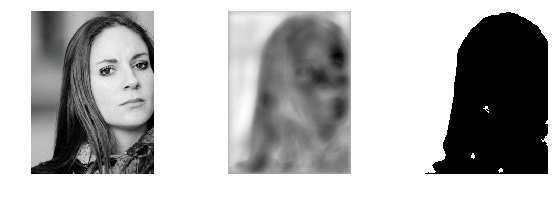

In [149]:
show_pred_image(u_net_bce, test_dataset, 8, 0.5)

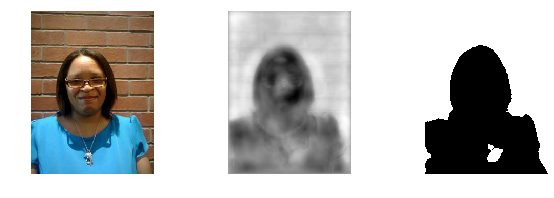

In [141]:
show_pred_image(u_net_bce, test_dataset, 18, 0.5)

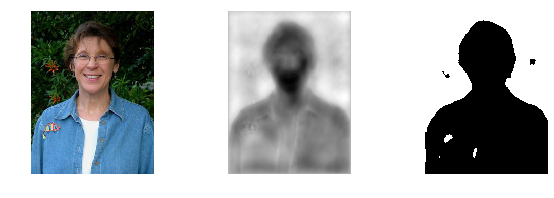

In [146]:
show_pred_image(u_net_bce, test_dataset, 0, 0.5)

После 10-ти эпох с оптимизатором sgd качество довольно хорошее, хотя есть небольшие области, отнесенные к неверному классу.

Обучение сети u_net с лосс-функцией DiceLoss

In [0]:
u_net_dice = UNet().cuda()
criterion_dice = DiceLoss(reduction='mean')
optimizer_dice = optim.SGD(u_net_dice.parameters(), lr=1e-3, momentum=0.9)

In [155]:
train_net(u_net_dice, criterion_dice, optimizer_dice, train_data_loader)

tensor(0.4838, device='cuda:0')
tensor(0.4789, device='cuda:0')
tensor(0.4343, device='cuda:0')
tensor(0.4432, device='cuda:0')
tensor(0.4916, device='cuda:0')
tensor(0.4253, device='cuda:0')
tensor(0.4481, device='cuda:0')
tensor(0.5389, device='cuda:0')
tensor(0.5474, device='cuda:0')
tensor(0.4284, device='cuda:0')
tensor(0.4174, device='cuda:0')
tensor(0.4942, device='cuda:0')
tensor(0.4026, device='cuda:0')
tensor(0.4101, device='cuda:0')
tensor(0.4656, device='cuda:0')
tensor(0.3709, device='cuda:0')
tensor(0.3925, device='cuda:0')
tensor(0.3588, device='cuda:0')
tensor(0.4037, device='cuda:0')
tensor(0.4479, device='cuda:0')
tensor(0.3655, device='cuda:0')
tensor(0.3735, device='cuda:0')
tensor(0.3124, device='cuda:0')
tensor(0.3367, device='cuda:0')
tensor(0.4088, device='cuda:0')
tensor(0.3926, device='cuda:0')
tensor(0.3500, device='cuda:0')
tensor(0.2972, device='cuda:0')
tensor(0.3351, device='cuda:0')
tensor(0.3026, device='cuda:0')
tensor(0.2969, device='cuda:0')
tensor(0

In [0]:
torch.save(u_net_dice.state_dict(), '/content/gdrive/My Drive/task_2/model_dice')

In [159]:
  evaluate_net(u_net_dice, test_data_loader, DiceLoss(reduction='mean'), DiceLoss(reduction='mean'), device='cuda')

(0.09615180144707362, 0.09615180144707362)

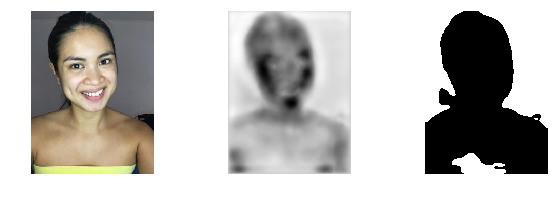

In [189]:
show_pred_image(u_net_dice, test_dataset, 2, 0.5)

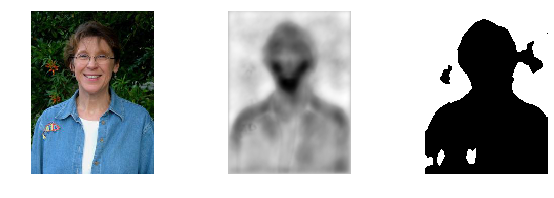

In [187]:
show_pred_image(u_net_dice, test_dataset, 0, 0.5)

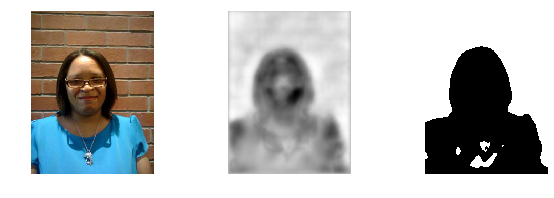

In [170]:
show_pred_image(u_net_dice, test_dataset, 18, 0.5)

Полученные маски хуже по качеству, контраст между фоном и изображением человека меньше, чем в предыдущем эксперименте. Поэтому маски, отрезанные по порогу, имеют довольно большие по размеру области, отнесенные к ложному классу.

Обучение сети u_net с лосс-функцией, представляющей из себя взвешенную сумму функций из предыдущих экспериментов.

In [0]:
class WeightedSumLoss(nn.Module):
  def __init__(self, dice_eps=1e-7, reduction='mean', dice_with_logits=True, weight_dice=0.5):
      super().__init__()
      self.dice = DiceLoss(eps=dice_eps, reduction=reduction, with_logits=dice_with_logits)
      self.bce = nn.BCEWithLogitsLoss(reduction=reduction)
      self.weight_dice = weight_dice
      
  def forward(self, logits, true_labels):
      return self.weight_dice * self.dice(logits, true_labels) + (1. - self.weight_dice) * self.bce(logits, true_labels)
      

In [0]:
u_net_sum = UNet().cuda()
criterion_sum = WeightedSumLoss()
optimizer_sum = optim.SGD(u_net_sum.parameters(), lr=1e-3, momentum=0.9)

In [192]:
train_net(u_net_sum, criterion_sum, optimizer_sum, train_data_loader)

tensor(0.5676, device='cuda:0')
tensor(0.5860, device='cuda:0')
tensor(0.5825, device='cuda:0')
tensor(0.5348, device='cuda:0')
tensor(0.5351, device='cuda:0')
tensor(0.5315, device='cuda:0')
tensor(0.5260, device='cuda:0')
tensor(0.5424, device='cuda:0')
tensor(0.5447, device='cuda:0')
tensor(0.5516, device='cuda:0')
tensor(0.5384, device='cuda:0')
tensor(0.4849, device='cuda:0')
tensor(0.5797, device='cuda:0')
tensor(0.5408, device='cuda:0')
tensor(0.4770, device='cuda:0')
tensor(0.4924, device='cuda:0')
tensor(0.4939, device='cuda:0')
tensor(0.5108, device='cuda:0')
tensor(0.4738, device='cuda:0')
tensor(0.4840, device='cuda:0')
tensor(0.4848, device='cuda:0')
tensor(0.5049, device='cuda:0')
tensor(0.5154, device='cuda:0')
tensor(0.4591, device='cuda:0')
tensor(0.4875, device='cuda:0')
tensor(0.4853, device='cuda:0')
tensor(0.4612, device='cuda:0')
tensor(0.4948, device='cuda:0')
tensor(0.4954, device='cuda:0')
tensor(0.4954, device='cuda:0')
tensor(0.4647, device='cuda:0')
tensor(0

In [0]:
torch.save(u_net_sum.state_dict(), '/content/gdrive/My Drive/task_2/model_sum')

In [195]:
  evaluate_net(u_net_sum, test_data_loader, WeightedSumLoss(reduction='mean'), DiceLoss(reduction='mean'), device='cuda')

(1.012271950642268, 0.09615180144707362)

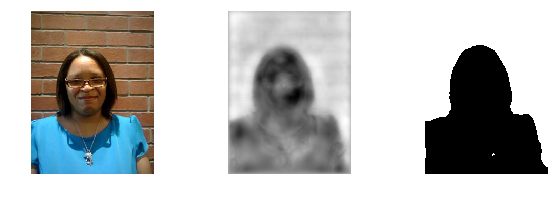

In [196]:
show_pred_image(u_net_sum, test_dataset, 18, 0.5)

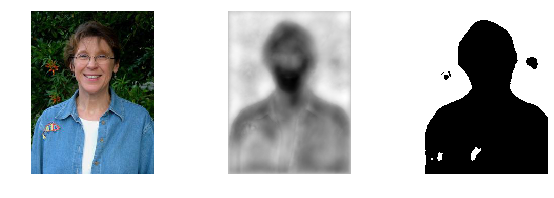

In [210]:
show_pred_image(u_net_sum, test_dataset, 0, 0.5)

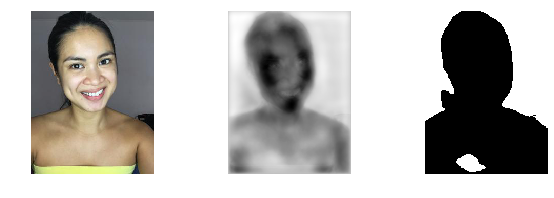

In [203]:
show_pred_image(u_net_sum, test_dataset, 2, 0.5)

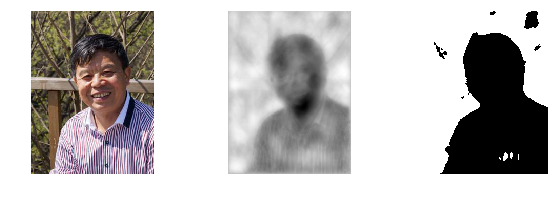

In [221]:
show_pred_image(u_net_sum, test_dataset, 15, 0.5)

Полученные результаты являются лучшими из трех проведенных экспериментов. Области, отнесенные к неверному классу после бинаризации маски, незначительны по размеру и количеству.

## LinkNet (3 балла)

Реализуйте архитектуру LinkNet с использованием энкодера, основанного на VGG13. Архитектура похожа на Unet, но вместо конкатенации слоёв используются skip-connections. Для реализации достаточно переписать структуру декодировщика из предыдущего пункта.

https://arxiv.org/pdf/1707.03718.pdf

In [0]:
class DecoderBlock_link(torch.nn.Module):
    def __init__(self, out_channels):
        super().__init__()

        self.upconv = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv1 = torch.nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv2 = torch.nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )

    def forward(self, down, left):
        x = torch.nn.functional.interpolate(down, scale_factor=2)
        x = self.upconv(x)
        x = self.conv1(left + x)
        x = self.conv2(x)
        return x

In [0]:
class Decoder_link(nn.Module):
    def __init__(self, num_filters, num_blocks):
        super().__init__()

        for i in range(num_blocks):
            self.add_module(f'block{num_blocks - i}', DecoderBlock_link(num_filters * 2**i))

    def forward(self, acts):
        up = acts[-1]
        for i, left in enumerate(acts[-2::-1]):
            up = self.__getattr__(f'block{i + 1}')(up, left)
        return up

In [0]:
class LinkNet(torch.nn.Module):
    def __init__(self, num_classes=1, num_filters=64, num_blocks=4):
        super().__init__()
        self.encoder = VGG13Encoder(num_blocks=num_blocks)
        self.decoder = Decoder_link(num_filters=64, num_blocks=num_blocks - 1)
        self.final = torch.nn.Conv2d(
            in_channels=num_filters, out_channels=num_classes, kernel_size=1
        )

    def forward(self, x):
        acts = self.encoder(x)
        x = self.decoder(acts)
        x = self.final(x)
        return x

In [0]:
link_net_bce = LinkNet().cuda()
criterion_bce = torch.nn.BCEWithLogitsLoss()
optimizer_bce = optim.SGD(link_net_bce.parameters(), lr=1e-3, momentum=0.9)

In [35]:
train_net(link_net_bce, criterion_bce, optimizer_bce, train_data_loader)

tensor(0.6801, device='cuda:0')
tensor(0.6663, device='cuda:0')
tensor(0.6695, device='cuda:0')
tensor(0.6740, device='cuda:0')
tensor(0.6744, device='cuda:0')
tensor(0.6699, device='cuda:0')
tensor(0.6244, device='cuda:0')
tensor(0.6455, device='cuda:0')
tensor(0.6511, device='cuda:0')
tensor(0.6726, device='cuda:0')
tensor(0.6280, device='cuda:0')
tensor(0.6306, device='cuda:0')
tensor(0.6153, device='cuda:0')
tensor(0.6197, device='cuda:0')
tensor(0.5821, device='cuda:0')
tensor(0.6263, device='cuda:0')
tensor(0.6118, device='cuda:0')
tensor(0.5730, device='cuda:0')
tensor(0.5458, device='cuda:0')
tensor(0.6240, device='cuda:0')
tensor(0.5409, device='cuda:0')
tensor(0.5190, device='cuda:0')
tensor(0.5229, device='cuda:0')
tensor(0.5371, device='cuda:0')
tensor(0.5394, device='cuda:0')
tensor(0.5566, device='cuda:0')
tensor(0.6699, device='cuda:0')
tensor(0.5164, device='cuda:0')
tensor(0.5490, device='cuda:0')
tensor(0.5474, device='cuda:0')
tensor(0.4616, device='cuda:0')
tensor(0

In [0]:
torch.save(link_net_bce.state_dict(), '/content/gdrive/My Drive/task_2/link_model_bce')

In [38]:
evaluate_net(link_net_bce, test_data_loader, nn.BCEWithLogitsLoss(reduction='mean'), DiceLoss(reduction='mean'), device='cuda')

(0.19881802135043675, 0.10983882140782145)

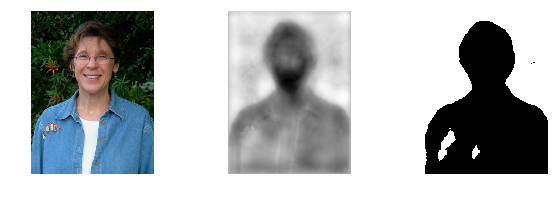

In [41]:
show_pred_image(link_net_bce, test_dataset, 0, 0.5)

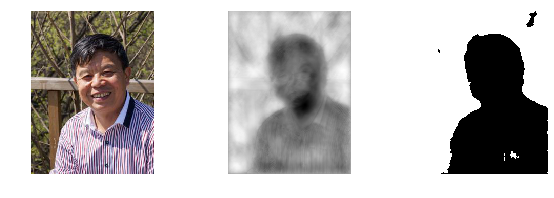

In [42]:
show_pred_image(link_net_bce, test_dataset, 15, 0.5)

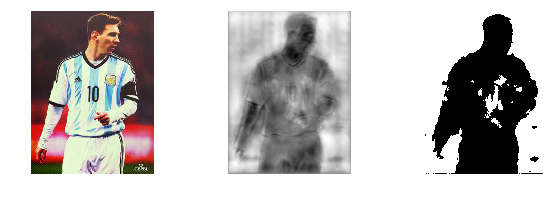

In [43]:
show_pred_image(link_net_bce, test_dataset, 25, 0.5)

In [0]:
link_net_dice = LinkNet().cuda()
criterion_dice = DiceLoss(reduction='mean')
optimizer_dice = optim.SGD(link_net_dice.parameters(), lr=1e-3, momentum=0.9)

In [47]:
train_net(link_net_dice, criterion_dice, optimizer_dice, train_data_loader)

tensor(0.4603, device='cuda:0')
tensor(0.4445, device='cuda:0')
tensor(0.4508, device='cuda:0')
tensor(0.4364, device='cuda:0')
tensor(0.4475, device='cuda:0')
tensor(0.4418, device='cuda:0')
tensor(0.4295, device='cuda:0')
tensor(0.3984, device='cuda:0')
tensor(0.4140, device='cuda:0')
tensor(0.4295, device='cuda:0')
tensor(0.4192, device='cuda:0')
tensor(0.3899, device='cuda:0')
tensor(0.4381, device='cuda:0')
tensor(0.3924, device='cuda:0')
tensor(0.3654, device='cuda:0')
tensor(0.3569, device='cuda:0')
tensor(0.3942, device='cuda:0')
tensor(0.2957, device='cuda:0')
tensor(0.3117, device='cuda:0')
tensor(0.3239, device='cuda:0')
tensor(0.3260, device='cuda:0')
tensor(0.3113, device='cuda:0')
tensor(0.3004, device='cuda:0')
tensor(0.4127, device='cuda:0')
tensor(0.3175, device='cuda:0')
tensor(0.3435, device='cuda:0')
tensor(0.2875, device='cuda:0')
tensor(0.3408, device='cuda:0')
tensor(0.2420, device='cuda:0')
tensor(0.3491, device='cuda:0')
tensor(0.2015, device='cuda:0')
tensor(0

In [0]:
torch.save(link_net_dice.state_dict(), '/content/gdrive/My Drive/task_2/link_model_dice')

In [50]:
evaluate_net(link_net_dice, test_data_loader, DiceLoss(reduction='mean'), DiceLoss(reduction='mean'), device='cuda')

(0.09229316314061482, 0.09229316314061482)

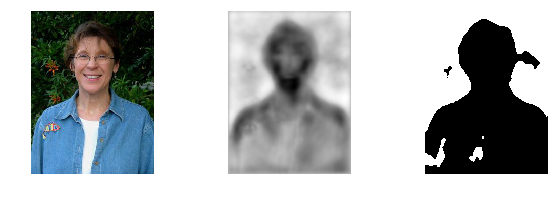

In [54]:
show_pred_image(link_net_dice, test_dataset, 0, 0.5)

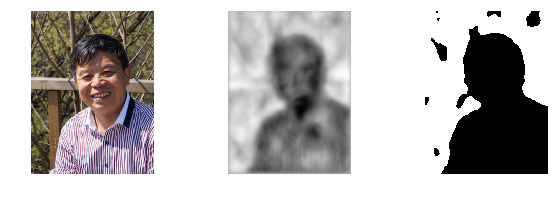

In [59]:
show_pred_image(link_net_dice, test_dataset, 15, 0.5)

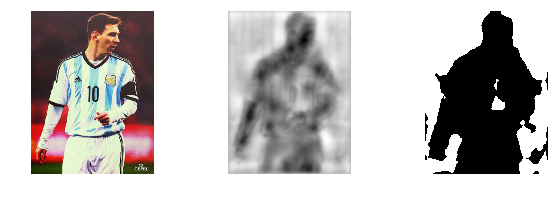

In [63]:
show_pred_image(link_net_dice, test_dataset, 25, 0.5)

In [29]:
link_net_sum = LinkNet().cuda()
criterion_sum = WeightedSumLoss(reduction='mean')
optimizer_sum = optim.SGD(link_net_sum.parameters(), lr=1e-3, momentum=0.9)

Downloading: "https://download.pytorch.org/models/vgg13-c768596a.pth" to /root/.torch/models/vgg13-c768596a.pth
532194478it [00:21, 24203427.79it/s]


In [33]:
train_net(link_net_sum, criterion_sum, optimizer_sum, train_data_loader)

tensor(0.5737, device='cuda:0')
tensor(0.5575, device='cuda:0')
tensor(0.5581, device='cuda:0')
tensor(0.5471, device='cuda:0')
tensor(0.5802, device='cuda:0')
tensor(0.5409, device='cuda:0')
tensor(0.5372, device='cuda:0')
tensor(0.5648, device='cuda:0')
tensor(0.5116, device='cuda:0')
tensor(0.5460, device='cuda:0')
tensor(0.4976, device='cuda:0')
tensor(0.5508, device='cuda:0')
tensor(0.5307, device='cuda:0')
tensor(0.4682, device='cuda:0')
tensor(0.5640, device='cuda:0')
tensor(0.5120, device='cuda:0')
tensor(0.4771, device='cuda:0')
tensor(0.5002, device='cuda:0')
tensor(0.4728, device='cuda:0')
tensor(0.4699, device='cuda:0')
tensor(0.5433, device='cuda:0')
tensor(0.4822, device='cuda:0')
tensor(0.4962, device='cuda:0')
tensor(0.5292, device='cuda:0')
tensor(0.4708, device='cuda:0')
tensor(0.3909, device='cuda:0')
tensor(0.5199, device='cuda:0')
tensor(0.5034, device='cuda:0')
tensor(0.5118, device='cuda:0')
tensor(0.4217, device='cuda:0')
tensor(0.4491, device='cuda:0')
tensor(0

In [0]:
torch.save(link_net_sum.state_dict(), '/content/gdrive/My Drive/task_2/link_model_sum')

In [35]:
evaluate_net(link_net_sum, test_data_loader, WeightedSumLoss(reduction='mean'), DiceLoss(reduction='mean'), device='cuda')

(0.16726255209909546, 0.09985466218656963)

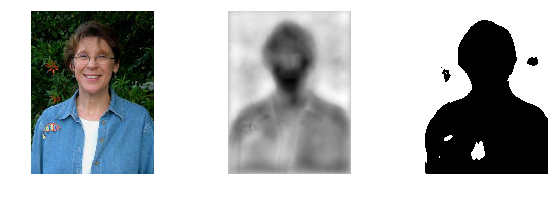

In [42]:
show_pred_image(link_net_sum, test_dataset, 0, 0.5)

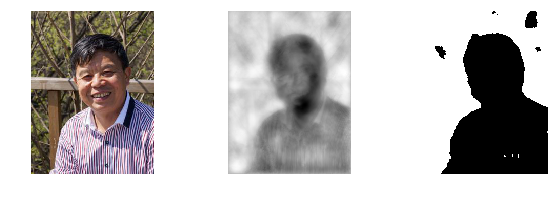

In [43]:
show_pred_image(link_net_sum, test_dataset, 15, 0.5)

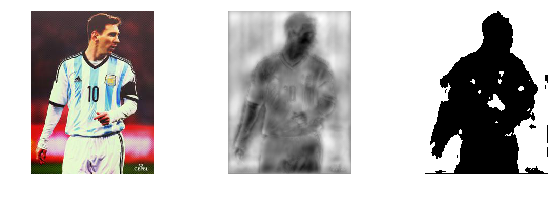

In [56]:
show_pred_image(link_net_sum, test_dataset, 25, 0.5)

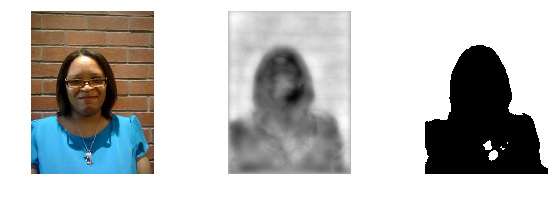

In [57]:
show_pred_image(link_net_sum, test_dataset, 18, 0.5)

Обучите LinkNet. Сравните LinkNet и Unet по качеству и скорости работы. Сделайте выводы. 

Как видно из проведенных с сетью link_net экспериментов, лучшее качество сегментации показывает сеть, обученная с лосс-функцией nn.BCEWithLogitsLoss, а худшее - DiceLoss. \\
Если же рассматривать эксперименты с обеими архитектурами, то лучший результат, на мой взгляд, был достигнут при использовании link_net с лосс-функцией nn.BCEWithLogitsLoss. Этот вывод основан преимущественно на количестве и размере артефактов в полученных масках. DiceLoss не всегда коррелирует с этим показателем и в некоторых экспериментах достигает меньших значений, хотя  внешний вид масок хуже. \\
Для оценки скорости работы запустим по одной эпохе на разных архитектурах с использованием одних и тех же оптимизатора и лосс-функции.

In [0]:
from time import time

In [62]:
u_net_bce = UNet().cuda()
criterion_bce = torch.nn.BCEWithLogitsLoss()
optimizer_bce = optim.SGD(u_net_bce.parameters(), lr=1e-3, momentum=0.9)
start = time()
train_net(u_net_bce, criterion_bce, optimizer_bce, train_data_loader, max_epochs=1)
end = time()
print('u_net time:', end - start)

tensor(0.6569, device='cuda:0')
tensor(0.6826, device='cuda:0')
tensor(0.6598, device='cuda:0')
tensor(0.6605, device='cuda:0')
tensor(0.6544, device='cuda:0')
tensor(0.6686, device='cuda:0')
tensor(0.6832, device='cuda:0')
tensor(0.6407, device='cuda:0')
tensor(0.6435, device='cuda:0')
tensor(0.6290, device='cuda:0')
tensor(0.5929, device='cuda:0')
tensor(0.6381, device='cuda:0')
tensor(0.6257, device='cuda:0')
tensor(0.6542, device='cuda:0')
tensor(0.6011, device='cuda:0')
tensor(0.6059, device='cuda:0')
tensor(0.6435, device='cuda:0')
tensor(0.6490, device='cuda:0')
tensor(0.6193, device='cuda:0')
tensor(0.6316, device='cuda:0')
tensor(0.6345, device='cuda:0')
tensor(0.5296, device='cuda:0')
tensor(0.5428, device='cuda:0')
tensor(0.5849, device='cuda:0')
tensor(0.5528, device='cuda:0')
tensor(0.6188, device='cuda:0')
tensor(0.6259, device='cuda:0')
tensor(0.6456, device='cuda:0')
tensor(0.6439, device='cuda:0')
tensor(0.5603, device='cuda:0')
tensor(0.5501, device='cuda:0')
tensor(0

In [64]:
link_net_bce = LinkNet().cuda()
criterion_bce = torch.nn.BCEWithLogitsLoss()
optimizer_bce = optim.SGD(link_net_bce.parameters(), lr=1e-3, momentum=0.9)
start = time()
train_net(link_net_bce, criterion_bce, optimizer_bce, train_data_loader, max_epochs=1)
end = time()
print('link_net time:', end - start)

tensor(0.6991, device='cuda:0')
tensor(0.7157, device='cuda:0')
tensor(0.6980, device='cuda:0')
tensor(0.6791, device='cuda:0')
tensor(0.6840, device='cuda:0')
tensor(0.6716, device='cuda:0')
tensor(0.6675, device='cuda:0')
tensor(0.6681, device='cuda:0')
tensor(0.6764, device='cuda:0')
tensor(0.6426, device='cuda:0')
tensor(0.6463, device='cuda:0')
tensor(0.6304, device='cuda:0')
tensor(0.6143, device='cuda:0')
tensor(0.5861, device='cuda:0')
tensor(0.6348, device='cuda:0')
tensor(0.6062, device='cuda:0')
tensor(0.6089, device='cuda:0')
tensor(0.5641, device='cuda:0')
tensor(0.5390, device='cuda:0')
tensor(0.5605, device='cuda:0')
tensor(0.5757, device='cuda:0')
tensor(0.6773, device='cuda:0')
tensor(0.6085, device='cuda:0')
tensor(0.5904, device='cuda:0')
tensor(0.5175, device='cuda:0')
tensor(0.6605, device='cuda:0')
tensor(0.5428, device='cuda:0')
tensor(0.5461, device='cuda:0')
tensor(0.5614, device='cuda:0')
tensor(0.5646, device='cuda:0')
tensor(0.4450, device='cuda:0')
tensor(0

По результатам экспериментов архитектура link_net не только демонстрирует лучшее качество результата, но и меньшее время работы, а значит, можно сделать вывод, что для решаемой задачи она является более предпочтительной.

## Бонус: постобработка изображений (1 балл)

В предложенной задаче на фотографиях необходимо сегментировать только центральное изображения. Артефакты, которые появляются на краях изображения, можно удалять с помощью постобработки (например, с помощью модуля https://scikit-image.org/docs/dev/api/skimage.morphology.html). 

Реализуйте какой-нибудь из методов постобработки, дающий прирост в качестве. Продемонстируйте несколько изображений, на которых постобработка будет оказывать влияние на результат сегментации.

## Бонус: существенное улучшение качества (2 балла)

Придумайте какой-нибудь трюк, который существенно (с учётом бонусного пункта 1) повысит качество (которое должно быть и так достаточно высоко). Не разрешается использовать дополнительные данные или другие предобученные кодировщики кроме VGG13.

Если вы что-то попробовали, но качество не повысилось, всё равно оформите этот пункт, даже за неудачные попытки могут быть начислены баллы.